# Medicare for All: Tax Analysis
#### Anne Bode, 2019

In [17]:
import csv
import copy
import numpy
import string

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

### Initiate Variables

In [18]:
#30 Trillion, over ten years based on think tank projections
TotalCost = 30000000000000
TotalYears = 10

#How much do we want to cover with new taxes (vs. growing budget deficit)
DesiredCoverage = 0.50

#growth rate assumptions (based on historical averages)
Inflation = 0.02
PopulationGrowth = 0.008
GDPGrowth = 0.02

#current rates
CurrentCorpTaxRate = 0.21
OASDItax = 0.124
HItax = 0.029
addtlHItax = 0.009

FilingStatus = ['Single',
                'Married filed jointly + Surviving Spouses',
                'Married filed separately',
                'HoH']

StandardDeduction = {'Single':12200,
                     'Married filed jointly + Surviving Spouses':24400,
                     'Married filed separately':12200,
                     'HoH':18350}

IncomeGroups ={
        'No adjusted gross income':[0,0],
        '$1 under $5,000':[1,5000],
        '$5,000 under $10,000':[5000,10000],
        '$10,000 under $15,000':[10000,15000],
        '$15,000 under $20,000':[15000,20000],
        '$20,000 under $25,000':[20000,25000],
        '$25,000 under $30,000':[25000,30000],
        '$30,000 under $40,000':[30000,40000],
        '$40,000 under $50,000':[50000,75000],
        '$50,000 under $75,000':[50000,75000],
        '$75,000 under $100,000':[75000,100000],
        '$100,000 under $200,000':[100000,200000],
        '$200,000 under $500,000':[200000,500000],
        '$500,000 under $1,000,000':[500000,1000000],
        '$1,000,000 under $1,500,000':[1000000,1500000],
        '$1,500,000 under $2,000,000':[1500000,2000000],
        '$2,000,000 under $5,000,000':[2000000,5000000],
        '$5,000,000 under $10,000,000':[5000000,10000000],
        '$10,000,000 or more':[10000000,10000000]}

Brackets2019Data = "Brackets2019.csv"
Brackets2017Data = "Brackets2017.csv"
FedRevData = "Federal Revenue.csv"
IncomeTaxData = "Income Taxes.csv"
PayrollTaxData = "Payroll Taxes.csv"

### Helper Functions

createdistribution()  
createfulldistribution()  
findaverages()  
isitcovered()  
CreateFedRevDict()

In [19]:
"""
******************************************************************************
CREATEDISTRIBUTION()

Function: get distribution of people within each IncomeGroup at $1 increment

Inputs:
    minincome, an int
    maxincome, an int
    totalnumber, an int

Outputs: list of [minincome, maxincome, total number of ppl, number of ppl per $1]
******************************************************************************
"""
def createdistribution(minincome,maxincome,totalnumber):
    if maxincome == minincome:
        numperdollar = totalnumber
    else:
        numperdollar = totalnumber/(maxincome-minincome)
        
    return [minincome,maxincome,totalnumber,
            numperdollar]

"""
******************************************************************************
CREATEFULLDISTRIBUTION()

Function: produce distribution of people at $1 increment for each line
(filing status, year, income group) in a given Income Tax Dictionary

Inputs:
    DictIncomeTax, a dictionary
    Year, an int
    IncomeGroups, a dictionary

Output: list of lists [status,
                       income group,
                       avgAGI,
                      [minincome, maxincome, total number of ppl, number of ppl per $1],
                      totalAGI]
******************************************************************************
"""
def createfulldistribution(DictIncomeTax,Year,IncomeGroups):
    fulldistro = []
    yr = str(Year)
    for status in DictIncomeTax:
        for group in DictIncomeTax[status][yr]:
            #for each group in each year in each filing status
            if group in IncomeGroups:
                #weed out the "Total" and other types that are duplicative
                distro = createdistribution(DictIncomeTax[status][yr][group][0],
                                            DictIncomeTax[status][yr][group][1],
                                            DictIncomeTax[status][yr][group][2])
                avgAGI = DictIncomeTax[status][yr][group][4]
                fulldistro.append([status,group,avgAGI,distro,
                                   DictIncomeTax[status][yr][group][3]])
    return fulldistro

"""
******************************************************************************
FINDAVERAGES()

Function: given a starting average, threshold, and distribution (number of ppl
per $1 increment), calculate two new averages on either side of threshold

Inputs:
    startavg, an int
    low, an int
    high, an int
    personperdoll, a float
    threshold, an int

Output: list of lists, [[new low avg and # of ppl],[new high avg and # of ppl]]
******************************************************************************
"""
def find_averages(startavg,low,high,personperdoll,threshold):
    
    #calculate number of people in each side of threshold
    lowdenom = (threshold - low) * personperdoll
    highdenom = (high - threshold) * personperdoll
    
    divisor = 2
    newlowavg = 0
    newhighavg = 0
    while newhighavg < threshold:
        #set the new low average to midpoint between the threshold and the low
        newlowavg = (threshold + low)/divisor
    
        #calculate what the new high avg is, given the new low avg, num of ppl on
        #either side, and starting avg
        newhighavg = ((startavg * (high - low) * personperdoll) - (lowdenom * newlowavg)) \
                    /highdenom
        divisor += 0.1
    return [[newlowavg,lowdenom], [newhighavg,highdenom]]

"""
******************************************************************************
ISITCOVERED()

Function: do your tax rate changes cover the desired % of the total cost?

Inputs:
    desiredcoverage, a float
    totalamount, an int
    coveredamount, a float

Output: Boolean
******************************************************************************
"""
def isitcovered(desiredcoverage,totalamount,coveredamount):
    if desiredcoverage * totalamount < coveredamount:
        return False
    else:
        return True

"""
******************************************************************************
CREATEFEDREVDICT()

Function: create dictionary of dictionaries for Federal Revenue Data by Year;
note that 2019-2024 are estimates

Inputs:
    RevFile, a csv file
Output: dictionary of dictionaries, format below:
{RevenueBucket:
    Year:
        Revenue}
******************************************************************************
"""

def CreateFedRevDict(RevFile):
    with open(RevFile) as f:
        FedRevList = list(list(yr) for yr in csv.reader(f, delimiter=','))
        f.close()
    DictFedRev = {}
    for i in range(1,4):
        DictFedRev[FedRevList[0][i]] = {}
    for yr in FedRevList[1:]:
        for i in range(1,4):
            yr[i] = int(yr[i])
            DictFedRev[FedRevList[0][i]][str(yr[0])] = yr[i]
    return DictFedRev

### Corporate Tax Functions

ProjectCorporateTax()   
RaiseCorporateTax()

In [20]:
"""
******************************************************************************
PROJECTCORPORATETAX()

Function: Projecting corporate tax, given a current rate and new rate (can be the same, if you're looking for a current state projection)
  
Inputs:  
    FedRevFile, a csv file  
    BaseYear, an int  
    StartYear, an int  
    Years, an int  
    CurrentCorpTaxRate, a float  
    NewCorpTaxRate, a float  
    Inflation, a float  
    GDPGrowth, a float  
  
Output: a list of corporate tax revenue
******************************************************************************
"""

def ProjectCorporateTax(FedRevFile,BaseYear,StartYear,Years,CurrentCorpTaxRate,
                        NewCorpTaxRate,Inflation,GDPGrowth):
    FedRevDict = CreateFedRevDict(FedRevFile)
    CorpTaxes = FedRevDict['Corporation Income Taxes'][str(BaseYear)]
    CorpIncome = CorpTaxes / CurrentCorpTaxRate
    
    for i in range(StartYear-BaseYear):
        CorpIncome = CorpIncome * (1 + GDPGrowth)
        CorpIncome = CorpIncome * (1 + Inflation)

    CorpTaxRev = []
    for j in range(Years):
        CorpTaxRev.append(CorpIncome * NewCorpTaxRate)
        CorpIncome = CorpIncome * (1 + GDPGrowth)
        CorpIncome = CorpIncome * (1 + Inflation)
        
    return CorpTaxRev

"""
******************************************************************************
RAISECORPORATETAX()

Function: raise corporate tax rate

Inputs:
    CurrentCorpTaxRate, a float
    increment, a float

Output: new corporate tax rate (current + increment), a float
******************************************************************************
"""
def RaiseCorporateTax(CurrentCorpTaxRate,increment):
    return round(CurrentCorpTaxRate + increment,4)

### Income Tax Functions
ProjectIncomeTax()  
CreateIncomeTaxDict()  
CreateBracketDict()  
newbracketdict()  
raiseincometaxbrackets()  

In [21]:
"""
******************************************************************************
PROJECTINCOMETAX()

Function: Project income tax revenue

Inputs:
    IncomeTaxFile, a csv file
    brackets, a dictionary
    StandardDeduction, a dictionary
    BaseYear, an int (2000 - 2016; historical data available)
    StartYear, an int (> 2019)
    Years, an int
    Inflation, a float
    PopulationGrowth, a float

Output: a list of income tax revenue for each year from StartYear to StartYear + Years
******************************************************************************
"""

def ProjectIncomeTax(IncomeTaxFile,BracketDict,StandardDeduction,IncomeGroups,
                     BaseYear,StartYear,Years,Inflation,PopulationGrowth):

    DictIncomeTax = CreateIncomeTaxDict(IncomeTaxFile)
    
    #take income tax dictionary and provide a distribution (number of people
    #per income dollar increment) for each income group
    incomedistribution = createfulldistribution(DictIncomeTax,BaseYear,IncomeGroups)
    
    #create a copy of StandardDeduction so that you can adjust thresholds for inflation
    StandDeduc = copy.deepcopy(StandardDeduction)
    brackets = copy.deepcopy(BracketDict)
    #update AGI and income group mins/max for inflation and population growth
    #between the base year and start year
    for i in range(StartYear-BaseYear):
        for line in incomedistribution:
            line[2] = line[2] * (1 + Inflation) #adjust avg AGI
            line[3][0] = line[3][0] * (1 + Inflation) #adjust min
            line[3][1] = line[3][1] * (1 + Inflation) #adjust min
            line[3][2] = line[3][2] * (1 + PopulationGrowth) #adjust totalppl
            line[3][3] = line[3][3] * (1 + PopulationGrowth) #adjust pplperdollar
    
    #update StandDeduc and tax bracket thresholds for inflation between
    #2019 (year our variables are drawn from) to start year
    for i in range(StartYear - 2019):
        for deduc in StandDeduc:
            StandDeduc[deduc] = StandDeduc[deduc] * (1 + Inflation)
        for status in brackets:
            for br in brackets[status]:
                brackets[status][br] = round(brackets[status][br] * (1+Inflation),0)
            
    IncomeTaxRev = []
    for j in range(Years):
        thisyearrev = 0
        
        #updated StandDeduc and tax bracket thresholds for inflation each year
        for status in brackets:
            for br in brackets[status]:
                brackets[status][br] = round(brackets[status][br] * (1+Inflation),0)
        for deduc in StandDeduc:
            StandDeduc[deduc] = StandDeduc[deduc] * (1 + Inflation)
        
        for line in incomedistribution:
            #if in StandDeduc (aka, if not "Total" etc)
            status = str(line[0])
            if status in StandDeduc:
                #reset avgAGI, min, and max to account for StandardDeduction
                #applicable for said filing status                
                AGIafterdeduction = max(line[2] - StandDeduc[status],0)
                minafterdeduction = max(line[3][0] - StandDeduc[status],0)
                maxafterdeduction = max(line[3][1] - StandDeduc[status],0)
                
                previousbr = 0
                previousthreshold = 0

                #create a list of thresholds
                thresholdlist = []
                for br in brackets[status]:
                    thresholdlist.append(brackets[status][br])
                
                #for each bracket in current filing status, set threshold
                for br in brackets[status]:
                    threshold = brackets[status][br]
                    if threshold <= minafterdeduction:
                        thisyearrev += previousbr * (threshold - previousthreshold) * line[3][2]
                        #if the threshold is below the income group min after
                        #deduction, multiply prior tax rate * (current threshold
                        #minus prior threshold) * total ppl in income group
                    elif threshold < maxafterdeduction:
                        avglist = find_averages(AGIafterdeduction,
                                                minafterdeduction,
                                                maxafterdeduction,
                                                line[3][3],
                                                threshold)
                        thisyearrev += (avglist[0][0] - previousthreshold) * avglist[0][1] * previousbr
                        thisyearrev += ((threshold - previousthreshold) * avglist[1][1] * previousbr)
                        thisyearrev += (avglist[1][0] - threshold) * avglist[1][1] * float(br)
                        #else, if the threshold is greater than the min after
                        #deduction but less than the max after deduction,
                        #calculate two new avg AGIs on either side of threshold
                        #and multiply lower half by prior rate; multiply upper
                        #half by prior rate up to threshold, higher rate for rest
                    elif previousthreshold <= minafterdeduction:
                        thisyearrev += (AGIafterdeduction - previousthreshold) * line[3][2] * previousbr
                        #else, if the current threshold is greater than max after deduction,
                        #but the previous threshold is less than or equal to your minimum
                        #(i.e. you fell into category #1 last time but you have 
                        #remainder income) multiply this REMAINDER income by
                        #the prior tax rate
                    
                    #if the threshold is greater than the max, and your AGI no revenue is added
                    
                    previousthreshold = brackets[status][br]
                    previousbr = float(br)
                
                #if the minimum of ur income group is greater than the maximum threshold,
                #multiply this excess income by the highest tax rate
                if max(thresholdlist) < minafterdeduction:
                    thisyearrev += (AGIafterdeduction - threshold) * line[3][2] * float(br)
            
            #update AGI/min/max/numppl for inflation and population growth each year
            line[2] = line[2] * (1 + Inflation) #adjust avg AGI
            line[3][0] = line[3][0] * (1 + Inflation) #adjust min
            line[3][1] = line[3][1] * (1 + Inflation) #adjust min
            line[3][2] = line[3][2] * (1 + PopulationGrowth) #adjust totalppl
            line[3][3] = line[3][3] * (1 + PopulationGrowth) #adjust pplperdollar
            
        IncomeTaxRev.append(thisyearrev)
        
    return IncomeTaxRev


"""
******************************************************************************
HELPER FUNCTIONS
******************************************************************************
"""

"""
******************************************************************************
CREATEINCOMETAXDICT()

Function: Create dictionary for income taxes

Input: IncomeTaxFile, a csv file

Output: Nested dictionary, format below
{filingstatus:
    year:
        IncomeGroup:
            [min AGI,
            max AGI,
            # of returns,
            total AGI,
            avg AGI,
            total taxable income,
            income tax collected]}
******************************************************************************            
"""
def CreateIncomeTaxDict(IncomeTaxFile):
    with open(IncomeTaxFile) as f:
        IncomeTaxList = list(list(yr) for yr in csv.reader(f, delimiter=','))
        f.close()

    DictIncomeTax = {}
    for yr in IncomeTaxList[1:]:
        for i in range(2,9):
            yr[i] = int(float(yr[i]))
        if str(yr[9]) not in DictIncomeTax.keys():
            DictIncomeTax[str(yr[9])] = {}
            #if filing status not in dict yet, add blank dict
        if str(yr[0]) not in DictIncomeTax[str(yr[9])].keys():
            DictIncomeTax[str(yr[9])][str(yr[0])] = {}
            #if year not in filing status dict yet, add blank dict
        if yr[4] != 0:
            avgAGI = yr[5]/yr[4]
        else:
            avgAGI = 0
        DictIncomeTax[str(yr[9])][str(yr[0])][str(yr[1])] = [yr[2],yr[3],yr[4],
                      yr[5],avgAGI,yr[6],yr[8]]
    return DictIncomeTax

"""
******************************************************************************
CREATEBRACKETDICT()

Function: Create dictionary of dictionaries with tax brackets and income thresholds

Input: BracketFile, a csv file

Output: Nested dictionary, format below:
{Filing Status:
    Bracket (Tax Rate):
        Threshold}
******************************************************************************
"""
def CreateBracketDict(BracketFile):
    with open(BracketFile) as f:
        BracketList = list(list(i) for i in csv.reader(f, delimiter=','))
    f.close()
    DictBrackets = {}
    for i in range(1,5):
        DictBrackets[BracketList[0][i]] = {}
        #initiate empty dictionaries for each filing status
    for br in BracketList[1:]:
        for i in range(1,5):
            br[i] = int(br[i])
            #convert all string cutoffs to integers
            DictBrackets[BracketList[0][i]][str(br[0])] = br[i]
    return DictBrackets

"""
******************************************************************************
2019 Bracket Dictionary
******************************************************************************
"""

BracketDict2019 = CreateBracketDict(Brackets2019Data)

"""
******************************************************************************
NEWBRACKETDICT()

Function: raise Tax Brackets and create new dictionary

Input: BracketFile, a csv file
       NewBracketsList, a list of brackets

Output: Nested dictionary, format below:
{Filing Status:
    Bracket (Tax Rate):
        Threshold}
******************************************************************************
"""
def newbracketdict(BracketDict,NewBracketsList):
    NewDict = {}
    for status in BracketDict.keys():
        NewDict[status] = {}
        i = 0
        for brs in BracketDict[status]:
            NewDict[status][str(NewBracketsList[i])] = BracketDict[status][brs]
            i += 1   
    return NewDict

"""
******************************************************************************
RAISEINCOMETAXBRACKETS()

Function: raising income tax brackets
    Progressive: ratio > 1
    Flat: ratio == 1

Inputs:
    BracketFile, a csv file
    ratio, an int (>= 1)
    increment, a float

Output: newbrlist, a list of new brackets
******************************************************************************
"""
def raiseincometaxbrackets(BracketDict,ratio,increment):    
    
    BracketList = []
    for key in BracketDict.keys():
        for key2 in BracketDict[key]:
            if float(key2) not in BracketList:
                BracketList.append(float(key2))
    
    for b in range(len(BracketList)):
        if ratio == 1:
            BracketList[b] =  round(BracketList[b] + increment,4)
            #if your ratio is 1 (i.e. flat tax increase), add increment to each
        elif ratio > 1:
            BracketList[b] = round(BracketList[b] + increment,4)
            addition = ((ratio * increment) - increment) / (len(BracketList)-1) * (b)
            BracketList[b] =  round(BracketList[b] + addition,4)
            #if your ratio >1 (i.e. progressive tax increase), add increment
            #to lowest rate, then scale up to comply w/ ratio across brackets
    return BracketList

### Payroll Tax Functions

ProjectPayrollTax()  
PayrollTaxin19  
CreatePayrollTaxDict()  
newpayrolllist()  
statusdistribution()  
raisepayrolltaxes()  
effectivepayrolltaxrate()

In [22]:
"""
******************************************************************************
PROJECTPAYROLLTAX()

Function: Projecting payroll taxes; with rate change(s)

Inputs:
    IncomeTaxFile, a csv file
    PayrollTaxFile, a csv file
    CurrentPayrollTaxList, a list
    NewPayrollTaxList, a list
    FilingStatus, a dictionary
    IncomeGroups, a dictionary
    BaseYear, an int (2000 - 2016; historical data available for income groups)
    StartYear, an int (>2019)
    Years, an int
    Inflation, a float
    PopulationGrowth, a float

Output: list of lists (array)
        [OASDI revenue,Base HI tax rev,Addtl HI tax rev]
        for each year
******************************************************************************
"""

def ProjectPayrollTax(IncomeTaxFile,PayrollTaxFile,CurrentPayrollTaxList,
                      NewPayrollTaxList,FilingStatus,IncomeGroups,BaseYear,
                      StartYear,Years,Inflation,PopulationGrowth):
    
    DictIncomeTax = CreateIncomeTaxDict(IncomeTaxFile)
    incomedistribution = createfulldistribution(DictIncomeTax,BaseYear,IncomeGroups)
    statdistribution = statusdistribution(incomedistribution,FilingStatus)
    DictPayrollTax = CreatePayrollTaxDict(PayrollTaxFile)
    NewHIThresholdDict = NewPayrollTaxList[4]
    
    #initiate starting OASDI and HI tax revs, using Base Year's rev data
    OASDItaxrev = DictPayrollTax[str(BaseYear)][2]
    HItaxrev = DictPayrollTax[str(BaseYear)][8]
    
    """
    We need to determine how much AGI is impacted by the additional HI rate
    Depends on filing status and corresponding threshold
    
    abovebelow is a dictionary of form:
        {status:
            [HI below threshold, HI above threshold],
            [HI % below threshold, HI % above threshold]
            [rev from status in Base Year, % of total rev from status in Base Year]]
            }
    
    loop through incomedistribution to calculate % of rev within each filing
    status that is above/below the OASDI and HI cap/threshold for the given status
    """

    abovebelow = {}
    for s in FilingStatus:
        abovebelow[s] = [[0,0],[0,0],statdistribution[s]]
    for line in incomedistribution:
        status = str(line[0])
        if status in FilingStatus:
            
            current = abovebelow[status]
            threshold = NewHIThresholdDict[status]
            avgAGI = line[2]
            minAGI = line[3][0]
            maxAGI = line[3][1]
            pplperdoll = line[3][3]
            totAGI = line[4]
            
            if threshold > minAGI and threshold < maxAGI:
                avglist = find_averages(avgAGI,minAGI,maxAGI,pplperdoll,threshold)
                #if the threshold falls between the low and high of income
                #group, calculate two new averages on either side
                #returns [newlowavg, numppl],[newhighavg,numppl]
                current[0][0] += avglist[0][0] * avglist[0][1]
                current[0][1] += avglist[1][0] * avglist[1][1]
                #multiply result to calc total AGI above/below threshold
                #add to below cap and above cap, as applicable
                
            elif threshold > maxAGI:
                current[0][0] += totAGI
                #else, if the threshold is above the max AGI, add totAGI to
                #"below threshold"
                
            else:
                current[0][1] += totAGI
                #else (threshold < min AGI), add totAGI to "above threshold"
                
        #now reset the percentages using your newly updated income totals
        allAGI = current[0][0] + current[0][1]
        current[1] = [current[0][0]/totAGI, current[0][1]/allAGI]
        abovebelow[status] = current
    
    """
    Now we can project future payroll tax revenue, knowing how much AGI is
    impacted by a change in rate
    """
    #estimate the total income pool; divide by HIrate + (addt'l % multiplied by
    #% of income subject to addt'l % (i.e. divide by the effective HI tax rate)
    abovethresholdpct = 0
    for status in abovebelow:
        abovethresholdpct += abovebelow[status][1][1] * abovebelow[status][2][1]
    HItotrev = HItaxrev/(CurrentPayrollTaxList[2]+(CurrentPayrollTaxList[3]*abovethresholdpct))
    AddtlHIrev = HItotrev * (CurrentPayrollTaxList[3]*abovethresholdpct)
    BaseHIrev = HItotrev * CurrentPayrollTaxList[2] 
   
    #update revenue from base year to start year, using inflation and population growth
    for y in range(StartYear-BaseYear):
        OASDItaxrev = OASDItaxrev * (1 + PopulationGrowth) * (1 + Inflation)
        AddtlHIrev = AddtlHIrev * (1 + PopulationGrowth) * (1 + Inflation)
        BaseHIrev = BaseHIrev * (1 + PopulationGrowth) * (1 + Inflation)
        HItotrev = HItotrev * (1 + PopulationGrowth) * (1 + Inflation)
    
    #if HI rate changed, multiply the change by the total rev and adjust
    if NewPayrollTaxList[2] != CurrentPayrollTaxList[2]:
        BaseHIrev += (NewPayrollTaxList[2] - CurrentPayrollTaxList[2]) * HItotrev
        
    #if addt'l HI rate changed, multiply the change * the % of income
    #above the threshold (for applicable filing status) * total rev and adjust
    if NewPayrollTaxList[3] != CurrentPayrollTaxList[3]:
        abovethresholdpct = 0
        for l in abovebelow:
            abovethresholdpct += abovebelow[status][1][1] * abovebelow[status][2][1]
        AddtlHIrev += (NewPayrollTaxList[3] - CurrentPayrollTaxList[3]) * abovethresholdpct * HItotrev
                
    PayrollTaxRev = []
    for j in range(Years):               
        PayrollTaxRev.append([OASDItaxrev,BaseHIrev,AddtlHIrev])
        
        #update from start to end, using inflation and population growth
        OASDItaxrev = OASDItaxrev * (1 + PopulationGrowth) * (1 + Inflation)
        BaseHIrev = BaseHIrev * (1 + PopulationGrowth) * (1 + Inflation)
        AddtlHIrev = AddtlHIrev * (1 + PopulationGrowth) * (1 + Inflation) 
    
    PayrollTaxRev = numpy.array(PayrollTaxRev)
    
    return PayrollTaxRev


"""
******************************************************************************
HELPER FUNCTIONS
******************************************************************************
"""

"""
******************************************************************************
2019 Payroll Tax Info: [OASDI rate, OASDI cap, HI rate, addt'l HI rate, threshold dictionary]
******************************************************************************
"""
PayrollTaxin19 = [0.124,132900, 0.029,0.009,
                  {'Single': 200000,
                   'Married filed jointly + Surviving Spouses':250000,
                   'Married filed separately': 125000,
                   'HoH':200000}]

"""
******************************************************************************
CREATEPAYROLLTAXDICT()

Function: create a dictionary of payroll tax data

Inputs: PayrollFile, a csv file

Output: dictionary, format below
{year:
    cap,
    OASDItax rate,
    OASDI collected
    HI tax rate,
    addt'l HI tax rate,
    Upper HI Threshold (Indiv),
    Upper HI Threshold (Married Joint),
    Upper HI Threshold (Married Separate),
    HI collected}
******************************************************************************
"""
def CreatePayrollTaxDict(PayrollFile):
    with open(PayrollFile) as f:
        PayrollTaxList = list(list(yr) for yr in csv.reader(f, delimiter=','))
        f.close()
    DictPayrollTax = {}
    for yr in PayrollTaxList[1:]:
        for r in range(1,12):
            if '0.' in yr[r]:
                yr[r] = int(yr[r].replace('0.',''))/10000
                #convert rates to percents
            else:
                yr[r] = int(yr[r])
        DictPayrollTax[str(yr[0])] = [yr[1],yr[2],yr[10],yr[3],yr[7],
                       yr[4],yr[5],yr[6],yr[11]]
    return DictPayrollTax

"""
******************************************************************************
NEWPAYROLLLIST()

Function: create new payroll list, preserving current OASDI rate

Inputs:
    oldpayrolllist, a list
    newHIrates, a list (new HI and addtl HI rate)
    
Output: list, updated for new HI rates
[OASDI rate, OASDI cap, HI rate, addt'l HI rate, threshold dictionary]
******************************************************************************  
"""
def newpayrolllist(oldpayrolllist,newHIrates):
    newlist = copy.deepcopy(oldpayrolllist)
    newlist[2] = newHIrates[0]
    newlist[3] = newHIrates[1]
    return newlist

"""
******************************************************************************
STATUSDISTRIBUTION()

Function: Calculating % of income in diff filing statuses, to be used to 
project Payroll Tax revenue changes

Inputs:
    incomedistribution, a list of lists
    FilingStatus, a dictionary
    
Output: dictionary, format below
{Filing Status:
    [revenue from status,
    % of total revenue from status]}
******************************************************************************
"""
def statusdistribution(incomedistribution,FilingStatus):
    #initiate a dictionary which will resemble {Status: rev from status}, and
    #initiate a rev from each status of 0
    statusdistro = {}
    totrev = 0
    for status in FilingStatus:
        statusdistro[status] = 0
        
    for line in incomedistribution:
        if line[0] in FilingStatus: 
            #weed out the "Total" etc lines, to avoid duplication
            status = str(line[0])
            statusdistro[status] = statusdistro[status] + line[4]
            totrev += line[4]
            #add total AGI from this line to the current rev from status
    for st in statusdistro:
        statusdistro[st] = [statusdistro[st],statusdistro[st]/totrev]
        #when complete, switch dictionary to resemble {Status: [rev from status,
        #% of total rev from status]}
    return statusdistro  

"""
******************************************************************************
RAISEPAYROLLTAXES()

Function: raising Payroll Tax rates

Inputs:
    CurrentPayrollList, a list
    incrementHI, a float
    incrementaddtl, a float

Output: a new payroll tax list, format below
[OASDI rate, OASDI cap, HI rate, addt'l HI rate, threshold dictionary]
******************************************************************************
"""
def raisepayrolltaxes(CurrentPayrollList,incrementHI,incrementaddtl):
    newHIrates = [round(CurrentPayrollList[2] + incrementHI,4),
                  round(CurrentPayrollList[3] + incrementaddtl,4)]
    NewPayrollTaxList = newpayrolllist(CurrentPayrollList,newHIrates)
    return NewPayrollTaxList

### Visualization Functions

taxrevlinechart(): line chart depicting cumulative taxes raised with and without changes  
newtaxrev(): line chart depicting cumulative change in taxes vs. desired coverage  
taxbarchart(): bar chart depicting cumulative taxes raised in each cat with/without changes, and the difference

In [32]:
"""
*******************************************************************************
VISUALIZATIONS
*******************************************************************************
"""
def taxrevlinechart(NoChangeArray,ChangeArray,StartYear,Years):
    
    ForGraph = []
    changesofar = 0
    nochangesofar = 0
    for yr in range(Years):
        nochangesofar += numpy.sum(NoChangeArray[yr])
        changesofar += numpy.sum(ChangeArray[yr])
        ForGraph.append([StartYear + yr, changesofar, "Tax Revenue Projections with Changes"])
        ForGraph.append([StartYear + yr, nochangesofar, "Current Tax Revenue Projections"])
    plt.figure(figsize = (11,8.5))
    TaxRevLineGraph = pd.DataFrame(ForGraph,columns = ['Year','Tax Revenue','Projection'])
    sns.set_palette("YlGnBu",2)
    fig = sns.lineplot(x="Year",y="Tax Revenue",hue="Projection",data=TaxRevLineGraph)
    yticklabels = ['{:,.2f}'.format(y) + 'T' for y in fig.get_yticks()/1000000000000]
    fig.set_yticklabels(yticklabels)
    fig.set(title = "Tax Revenue Collected With and Without Changes",
             xlabel = "Year",
             ylabel="Tax Revenue (in Trillions of Dollars)")
    
    return None

def newtaxrev(DiffArray,StartYear,Years,DesiredCoverage,TotalCost):
    
    ForGraph = []
    diffsofar = 0
    for yr in range(Years):
        diffsofar += numpy.sum(DiffArray[yr])
        ForGraph.append([StartYear + yr, DesiredCoverage * TotalCost,"Desired Coverage"])
        ForGraph.append([StartYear + yr, diffsofar, "Difference in Tax Revenue"])
    plt.figure(figsize = (11,8.5))
    TaxRevLineGraph = pd.DataFrame(ForGraph,columns = ['Year','Tax Revenue','Projection'])
    sns.set_palette("RdBu",2)
    fig = sns.lineplot(x="Year",y="Tax Revenue",hue="Projection",data=TaxRevLineGraph)
    yticklabels = ['{:,.2f}'.format(y) + 'T' for y in fig.get_yticks()/1000000000000]
    fig.set_yticklabels(yticklabels)
    fig.set(title = "Change in Tax Revenue vs. Desired Coverage",
             xlabel = "Year",
             ylabel="Tax Revenue (in Trillions of Dollars)")
    
    return None
        
def taxbarchart(barcharttotals):
    
    ForGraph2 = []
    revtypes = {"Income":4,"OASDI":0, "HI":1, "Addtl HI":2, "Corporate":3}
    projectdict = {"Current Tax Revenue Projections":0,"Tax Revenue Projections with Changes":1,
                   "Difference in TaxRevenue":2}
    for pr in projectdict.keys():
        for r in revtypes.keys():
            ForGraph2.append([barcharttotals[projectdict[pr]][revtypes[r]],r,pr])
    plt.figure(figsize = (11,8.5))
    TaxCatBarChart = pd.DataFrame(ForGraph2,columns = ['Revenue','Category','Projection'])
    sns.set_palette("YlGnBu",4)
    fig2 = sns.barplot(x="Category",y="Revenue",hue="Projection",data=TaxCatBarChart)
    yticklabels = ['{:,.2f}'.format(y) + 'T' for y in fig2.get_yticks()/1000000000000]
    fig2.set_yticklabels(yticklabels)
    fig2.set(title = "Tax Revenue by Category",
             xlabel = "Tax Category",
             ylabel="Tax Revenue (in Trillions of Dollars)")
    
    return None

### Effective Rates

effectiveincometax()  
effectivepayrolltax()  
totaleffectivetaxrate()  
effectiveratechangesall()

In [34]:
"""
******************************************************************************
EFFECTIVEINCOMETAX()

Function: determine effective tax rate for a person with a given AGI, status,
and at a specified year

Inputs:
    Year, an int
    Income, an int
    Status, a string (from FilingStatus list)
    BracketDict, a dictionary
    StandardDeduction, a dictionary
    Inflation, a dictionary

Output: effective tax rate, a float
******************************************************************************
"""
def effectiveincometax(Year,Income,Status,BracketDict,StandardDeduction,
                       Inflation):
    IncomeTaxesPaid = 0
    StandDeduc = StandardDeduction[Status]
    
    #create a list, depending on filing status, of tax rates and thresholds
    myfilingstatusbrlist = []
    for br in BracketDict[Status]:
        myfilingstatusbrlist.append([br,BracketDict[Status][br]])
    
    #adjust thresholds and standard deduction for inflation, from 2019 to specified year
    for y in range(Year-2019):
        for l in myfilingstatusbrlist:
            l[1] = l[1] * (1 + Inflation)
        StandDeduc = StandDeduc * (1 + Inflation)
    
    TaxableIncome = Income - StandDeduc
    
    #for each tax bracket, set the rate, threshold, and next threshold (0 if end of rates)
    for br in range(len(myfilingstatusbrlist)):
        rate = float(myfilingstatusbrlist[br][0])
        threshold = float(myfilingstatusbrlist[br][1])
        if br + 1 < len(myfilingstatusbrlist):
            nextthreshold = float(myfilingstatusbrlist[br+1][1])
        else:
            nextthreshold = 0

        if TaxableIncome >= threshold:
            if TaxableIncome < nextthreshold or nextthreshold == 0:
                IncomeTaxesPaid = IncomeTaxesPaid + (rate * (TaxableIncome - threshold))
                #if your taxable income >= threshold, but < next threshold (or
                #at the highest bracket already), multiply the current rate
                #by your taxable income minus the current threshold
            elif TaxableIncome >= nextthreshold:
                IncomeTaxesPaid = IncomeTaxesPaid + (rate * (nextthreshold - threshold))
                #if your taxable income >= threshold, and >= next threshold,
                #multiply the current rate by (nextthreshold - current threshold)
    
    if Income == 0:
        return 0
    
    else:
        return round(IncomeTaxesPaid/Income,4)

"""
******************************************************************************
EFFECTIVEPAYROLLTAX()

Function: determine effective payroll tax rate in a given year for a person
with a given AGI and status

Inputs:
    Year, an int
    Income, an int
    Status, a string (in FilingStatus)
    PayrollTaxList, a list
    Inflation, a float

Output: effective tax rate, a float
******************************************************************************
"""
def effectivepayrolltax(Year,Income,Status,PayrollTaxList,Inflation):
    
    PayrollTaxesPaid = 0
    HIthresholds = PayrollTaxList[4]
    #mypayrollist is a list of [OASDIrate,OASDIcap,HIrate,addtlHIrate,
    #my addtlHI threshold]
    mypayrolllist = [PayrollTaxList[0],PayrollTaxList[1],PayrollTaxList[2],
                     PayrollTaxList[3],HIthresholds[Status]]
    
    #adjust threshold for inflation since 2019
    for y in range(Year-2019):
        mypayrolllist[4] = mypayrolllist[4] * (1 + Inflation)
    
    #if income > OASDI cap, multiply OASDI rate by OASDI cap and divide by two
    #(to adjust for 1/2 paid by employer, 1/2 by employee)
    #otherwise, multiply income by OASDI rate and divide by two
    if Income > mypayrolllist[1]:
        PayrollTaxesPaid += (mypayrolllist[0] * mypayrolllist[1])/2
    else:
        PayrollTaxesPaid += (mypayrolllist[0] * Income)/2
    
    #if income > HI threshold, multiply addtl HI rate by income above threshold
    if Income > mypayrolllist[4]:
        PayrollTaxesPaid += (mypayrolllist[3] * (Income - mypayrolllist[4]))
    
    #multiply HI rate by income and divide by two
    PayrollTaxesPaid += (mypayrolllist[2] * Income)/2
    
    if Income == 0:
        return 0
    else:
        return round(PayrollTaxesPaid/Income,4)

"""
*******************************************************************************
TOTALEFFECTIVETAXRATE()

Function: Determine total effective tax rate

Inputs:
    BracketDict, a dictionary
    PayrollTaxList, a list
    Year, an int
    Status, a String
    Inflation, a float
    
    Defaults:
        StandardDeduction, a dictionary

Output:
    total effective tax rate, a float
*******************************************************************************
"""
def totaleffectivetaxrate(BracketDict,PayrollTaxList,Year,Income,Status,Inflation,
                          StandardDeduction = StandardDeduction):
    incomet = effectiveincometax(Year,Income,Status,BracketDict,StandardDeduction,
                       Inflation)
    payrollt = effectivepayrolltax(Year,Income,Status,PayrollTaxList,Inflation)
    return incomet + payrollt

#print(totaleffectivetaxrate(BracketDict2019,PayrollTaxin19,2020,75000,'Single',Inflation,))

"""
*******************************************************************************
EFFECTIVERATECHANGESALL

Function: determining effective tax rate change for a person with a given AGI

Inputs:
    Year, an int
    OldBracketDict, a dictionary
    NewBracketDict, a dictionary
    Inflation, a float
    OldPayrollTaxList, a list
    NewPayrollTaxList, a list
    StandardDeduction, a dictionary (preset)
    FilingStatus, a list (preset)
    
Output: chart displaying effective change across 25k increments

Column 1 = Income
Column 2 = Filing Status
Column 3 = Effective Tax Rate
Column 4 = Rate or Change in Rate (Category)
*******************************************************************************
"""
def effectiveratechangesall(Year,OldBracketDict,NewBracketDict,
                            Inflation,OldPayrollTaxList,NewPayrollTaxList,
                            StandardDeduction = StandardDeduction,
                            FilingStatus = FilingStatus):
    
    for st in FilingStatus:
        result = []
        for income in range(0,525000,25000):
            originalincome = effectiveincometax(Year,income,st,OldBracketDict,
                                                StandardDeduction,Inflation)
            newincome = effectiveincometax(Year,income,st,NewBracketDict,
                                           StandardDeduction,Inflation)
            originalpayroll = effectivepayrolltax(Year,income,st,OldPayrollTaxList,
                                                  Inflation)
            newpayroll = effectivepayrolltax(Year,income,st,NewPayrollTaxList,
                                             Inflation)
            originaltotal = originalincome + originalpayroll
            newtotal = newincome + newpayroll
            
            result.append([int(income/1000),newtotal,"Effective Tax Rate"])
            result.append([int(income/1000),newtotal-originaltotal,"Effective Rate Change"])
        chartdata = pd.DataFrame(result,columns = ['Income',
                                                   'Rate',
                                                   'Effective Rate Cat'])
    
        plt.figure(figsize = (11,8.5))
        sns.set_palette("YlGnBu",4)
        fig = sns.barplot(x="Income",y="Rate",hue="Effective Rate Cat",data=chartdata,ci=None)
        fig.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
        plt.ylim(0,0.55)
        yticklabels = ['{:.2%}'.format(y) for y in fig.get_yticks()]
        fig.set_yticklabels(yticklabels)
        fig.set(title = "New Effective Tax Rate and Change - " + str(st),
                xlabel = "Income (in thousands)",
                ylabel= "Effective Tax Rate")
        
    return None

NewBracketDict = newbracketdict(BracketDict2019,[0.10,0.20,0.30,0.40,0.50,0.60,0.70])

#print(effectiveratechangesall(2025,BracketDict2019,NewBracketDict,Inflation,
#                              PayrollTaxin19,PayrollTaxin19,))


### Project Tax Revenue

In [30]:
"""
*******************************************************************************
PROJECTTAXREVENUE()

Function: Project future tax revenues (income, payroll, corporate)

Inputs:
    BracketDict, a dictionary
    OldCorpTaxRate, a float
    NewCorpTaxRate, a float
    OldPayrollTaxList, a list
    NewPayrollTaxList, a list
    StartYear, an int
    Years, an int
    Inflation, a float
    PopulationGrowth, a float
    GDPGrowth, a float
        
    Default:
        IncomeTaxFile, a csv file
        StandardDeduction, a dictionary
        IncomeGroups, a dictionary
        FedRevFile, a csv file
        PayrollTaxFile, a csv file
        FilingStatus, a list
        BaseYearIP, an int (2016 latest for Income Tax Data/Payroll Tax)
        BaseYearC, an int (2018 latest for Corporate Tax Data)
        
Output: array of tax revenue for each tax category, for each year from
        StartYear to (StartYear + Years) - 1
        [OASDI Rev, Base HI Rev, Addt'l HI Rev, Corp Tax, Income Tax]
*******************************************************************************
"""
def projecttaxrevenue(BracketDict,OldCorpTaxRate,NewCorpTaxRate,
                      OldPayrollTaxList,NewPayrollTaxList,StartYear,Years,
                      Inflation,PopulationGrowth,GDPGrowth,
                      IncomeTaxFile = IncomeTaxData,
                      StandardDeduction = StandardDeduction,
                      IncomeGroups = IncomeGroups,
                      FedRevFile = FedRevData,
                      PayrollTaxFile = PayrollTaxData,
                      FilingStatus = FilingStatus,
                      BaseYearIP = 2016,
                      BaseYearC = 2018):
    #Generate arrays for each year of tax revenue projection
    PayrollTaxRev = ProjectPayrollTax(IncomeTaxFile,PayrollTaxFile,
                                          OldPayrollTaxList,NewPayrollTaxList,
                                          FilingStatus,IncomeGroups,BaseYearIP,
                                          StartYear,Years,Inflation,PopulationGrowth)
    CorpTaxRev = ProjectCorporateTax(FedRevFile,BaseYearC,StartYear,Years,
                                       OldCorpTaxRate,NewCorpTaxRate,
                                       Inflation,GDPGrowth)
    IncomeTaxRev = ProjectIncomeTax(IncomeTaxFile,BracketDict,StandardDeduction,
                                      IncomeGroups,BaseYearIP,StartYear,Years,Inflation,
                                      PopulationGrowth)
    
    #Aggregate arrays for each year of tax revenue projection
    TaxRev = []
    for yr in range(Years):
        TaxRev.append([PayrollTaxRev[yr][0],PayrollTaxRev[yr][1],PayrollTaxRev[yr][2],
                       CorpTaxRev[yr],IncomeTaxRev[yr]])        
    return numpy.array(TaxRev)

#print(projecttaxrevenue(BracketDict2019,CurrentCorpTaxRate,CurrentCorpTaxRate,
#                        PayrollTaxin19,PayrollTaxin19,2020,10,
#                        Inflation,PopulationGrowth,GDPGrowth))

### Compare Projections

In [ ]:
"""
*******************************************************************************
COMPAREPROJECTIONS()

Function: project future tax (income, payroll, corporate) with and without
          changes, and compare the difference

Inputs:
    OldBracketDict, a dictionary
    NewBracketDict, a dictionary
    OldCorpTaxRate, a float
    NewCorpTaxRate, a float
    OldPayrollTaxList, a list
    NewPayrollTaxList, a list
    StartYear, an int
    Years, an int
    Inflation, a float
    PopulationGrowth, a float
    GDPGrowth, a float
    
    Default:
        DesiredCoverage (set to 0 unless changed)
        TotalCost (set to 0 unless changed)
        Visualization (set to False unless changed)

Output:
    An array of the tax revenue for each category from StartYear to 
    (StartYear + Years) - 1    
    [[OASDI, HI, Addtl HI, Corp Tax, Income Tax] * Years -- projected w/ no changes,
    [[OASDI, HI, Addtl HI, Corp Tax, Income Tax] * Years -- projected w/ changes,
    [[OASDI, HI, Addtl HI, Corp Tax, Income Tax] * Years -- difference in each cat,
    TotalDiff -- total cumulativetax revenue difference]
    
    Plots four charts (see above) if Visualization == True
*******************************************************************************
"""
def compareprojections(OldBracketDict,NewBracketDict,
                       OldCorpTaxRate,NewCorpTaxRate,
                       OldPayrollTaxList,NewPayrollTaxList,
                       StartYear,Years,Inflation,PopulationGrowth,GDPGrowth,
                       DesiredCoverage = 0,
                       TotalCost = 0,
                       Visualization = False):
    
    #project tax revenue with no changes
    nochange = projecttaxrevenue(OldBracketDict,OldCorpTaxRate,OldCorpTaxRate,
                                 OldPayrollTaxList,OldPayrollTaxList,
                                 StartYear,Years,Inflation,PopulationGrowth,GDPGrowth)
  
    #project tax revenue with specified changes
    withchange = projecttaxrevenue(NewBracketDict,OldCorpTaxRate,NewCorpTaxRate,
                                   OldPayrollTaxList,NewPayrollTaxList,
                                   StartYear,Years,Inflation,PopulationGrowth,GDPGrowth)
    
    #calculate total rev collected per category, with and without rate changes 
    TaxCatTotals = [sum(x) for x in zip(*nochange)]
    ChangedTaxCatTotals = [sum(x) for x in zip(*withchange)]
    #calculate the difference per year per cat, total diff per year per cat, along with total diff
    DiffList = withchange - nochange
    DiffListTotals = [sum(x) for x in zip(*DiffList)]
    TotalDiff = numpy.sum(withchange) - numpy.sum(nochange)
    
    if Visualization == True:
        barcharttotals = [TaxCatTotals,ChangedTaxCatTotals,DiffListTotals]
        taxrevlinechart(nochange,withchange,StartYear,Years)
        newtaxrev(DiffList,StartYear,Years,DesiredCoverage,TotalCost)
        taxbarchart(barcharttotals)
        effectiveratechangesall(StartYear + Years,OldBracketDict,NewBracketDict,
                                Inflation,OldPayrollTaxList,NewPayrollTaxList)
    
    return [nochange,withchange,DiffList,TotalDiff]

#NewBracketDict = newbracketdict(BracketDict2019,[0.10,0.20,0.30,0.40,0.50,0.60,0.70])
#NewPayrollTaxList = newpayrolllist(PayrollTaxin19,[0.05,0.02])
#compareprojections(BracketDict2019,NewBracketDict,
#                   CurrentCorpTaxRate,0.325,
#                   PayrollTaxin19,NewPayrollTaxList,
#                   2020,10,Inflation,PopulationGrowth,GDPGrowth,
#                   DesiredCoverage = 0.25, TotalCost = 30000000000000,
#                   Visualization = True)


### Marginal Changes

marginaltaxincrease()  
marginalrevenuegain()

In [ ]:
"""
*******************************************************************************
MARGINALTAXINCREASE()

Function: Determine marginal tax increases for a given status/income and increment
(i.e. payroll taxes have lower marginal impact on high earners due to caps)

Inputs:    
    OldBracketDict, a dictionary
    OldPayrollTaxList, a list
    ratio, an int
    increment, a float
    Year, an int
    Income, an int
    Status, a string
    Inflation, a float
    
Output: list of lists
    [[Income Tax, Incremental change in effective tax rate],
    [HI Tax, Incremental change in effective tax rate],
    [Addt'l HI Tax, Incremental change in effective tax rate]
    [Corp Tax, 0]]
*******************************************************************************
"""

def marginaltaxincrease(OldBracketDict,OldPayrollTaxList,
                        ratio,increment,Year,Income,Status,Inflation):
    
    newincomebrlist = raiseincometaxbrackets(OldBracketDict,ratio,increment)
    newbracketdict_ = newbracketdict(OldBracketDict,newincomebrlist)
    newHIpayrolltaxlist = raisepayrolltaxes(OldPayrollTaxList,increment*2,0)
    newaddtlHIpayrolltaxlist = raisepayrolltaxes(OldPayrollTaxList,0,increment*2)
    #calculate total effective tax rate given no changes
    nochange = totaleffectivetaxrate(OldBracketDict,OldPayrollTaxList,Year,Income,
                                     Status,Inflation)

    #calculate total effective tax rate given incremental change in income tax
    incometaxchangerate = totaleffectivetaxrate(newbracketdict_,OldPayrollTaxList,
                                                Year,Income,Status,Inflation)
    
    #calculate total effective tax rate given incremental change in HI payroll tax
    HItaxchangerate = totaleffectivetaxrate(OldBracketDict,newHIpayrolltaxlist,Year,
                                            Income,Status,Inflation)
    
    #calculate total effective tax rate fiven incremental change in addt'l payroll tax
    addtlHItaxchangerate = totaleffectivetaxrate(OldBracketDict,newaddtlHIpayrolltaxlist,
                                                 Year,Income,Status,Inflation)
    
    #return list of lists, 
    return [['IncomeTax',round(incometaxchangerate - nochange,4)],
             ['HITax',round(HItaxchangerate - nochange,4)],
            ['AddtlHITax',round(addtlHItaxchangerate - nochange,4)],
            ['CorpTax',0]]

#print(marginaltaxincrease(BracketDict2019,PayrollTaxin19,2,0.001,2029,100000,
#                          'Married filed jointly + Surviving Spouses',Inflation))

"""
*******************************************************************************
MARGINALREVENUEGAIN()

Function: Determine marginal gain in tax revenue for a given increment

Inputs:
        OldBracketDict, a dictionary
        OldCorpTaxRate, a float
        OldPayrollTaxList, a list
        StartYear, an int
        Years, an int
        Inflation, a float
        PopulationGrowth, a float
        GDPGrowth, a float
        ratio, an int
        increment, a float        
    
Output: list of lists
    [[Income Tax, Marginal change in tax revenue],
    [HI Tax, Marginal change in tax revenue],
    [Addt'l HI Tax, Marginal change in tax revenue]
    [Corp Tax, Marginal change in tax revenue]]
*******************************************************************************
"""
def marginalrevenuegain(OldBracketDict,OldCorpTaxRate,OldPayrollTaxList,
                        StartYear,Years,Inflation,PopulationGrowth,
                        GDPGrowth,ratio,increment):
    
    #generate new tax rates by raising each by increment
    newincomebrlist = raiseincometaxbrackets(OldBracketDict,ratio,increment)
    NewBracketDict = newbracketdict(OldBracketDict,newincomebrlist)
    newHIpayrolltaxlist = raisepayrolltaxes(OldPayrollTaxList,increment,0)
    newaddtlHIpayrolltaxlist = raisepayrolltaxes(OldPayrollTaxList,0,increment)
    NewCorpTaxRate = RaiseCorporateTax(OldCorpTaxRate,increment)
    
    #project tax revenue given one increment of change in each tax rate type    
    incometaxrevchange = compareprojections(OldBracketDict,NewBracketDict,
                                            OldCorpTaxRate,OldCorpTaxRate,
                                            OldPayrollTaxList,OldPayrollTaxList,
                                            StartYear,Years,Inflation,
                                            PopulationGrowth,GDPGrowth)

    HItaxrevchange = compareprojections(OldBracketDict,OldBracketDict,
                                        OldCorpTaxRate,OldCorpTaxRate,
                                        OldPayrollTaxList,newHIpayrolltaxlist,
                                        StartYear,Years,Inflation,
                                        PopulationGrowth,GDPGrowth)

    addtlHItaxrevchange = compareprojections(OldBracketDict,OldBracketDict,
                                             OldCorpTaxRate,OldCorpTaxRate,
                                             OldPayrollTaxList,newaddtlHIpayrolltaxlist,
                                            StartYear,Years,Inflation,
                                            PopulationGrowth,GDPGrowth)

    corptaxrevchange = compareprojections(OldBracketDict,OldBracketDict,
                                          OldCorpTaxRate,NewCorpTaxRate,
                                          OldPayrollTaxList,OldPayrollTaxList,
                                          StartYear,Years,Inflation,
                                          PopulationGrowth,GDPGrowth)
    
    return [['IncomeTax',incometaxrevchange[3]],['HITax',HItaxrevchange[3]],
            ['AddtlHITax',addtlHItaxrevchange[3]],['CorpTax',corptaxrevchange[3]]]

#print(marginalrevenuegain(BracketDict2019,CurrentCorpTaxRate,
#                          PayrollTaxin19,2020,10,Inflation,PopulationGrowth,
#                          GDPGrowth,5,0.001))

### Algo: Raise all rates, with constraints


Covered $8,324,051,228,004; 27.75% of the total cost ($30,000,000,000,000) vs. goal of 25.0%

New Income Brackets: [0.1175, 0.155, 0.2725, 0.31, 0.4075, 0.455, 0.4925]
New HI Payroll Tax Rates: [0.0465, 0.0265]
New Corporate Tax Rate: 0.2275



[[0.1175, 0.155, 0.2725, 0.31, 0.4075, 0.455, 0.4925],
 [0.0465, 0.0265],
 0.2275,
 8324051228004.77,
 0,
 8324051228004.77]

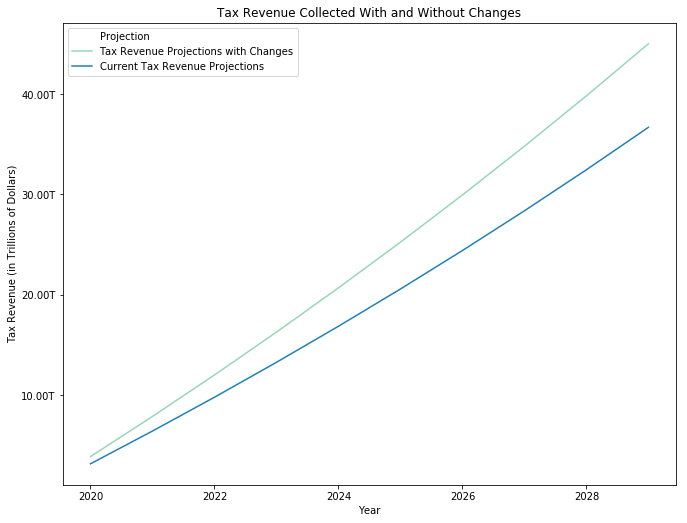

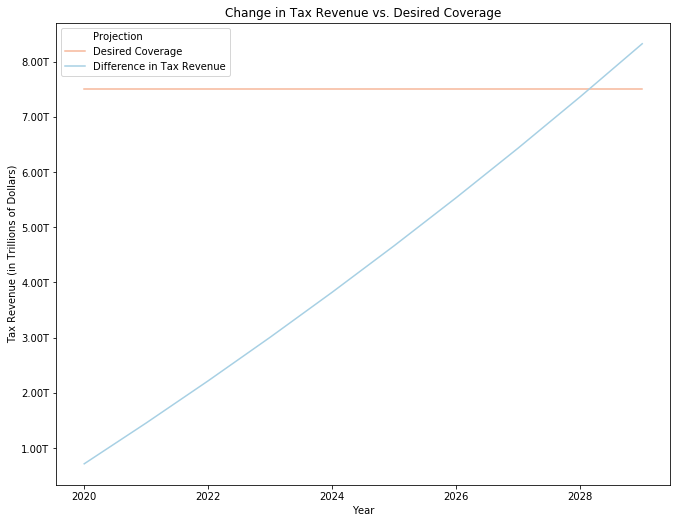

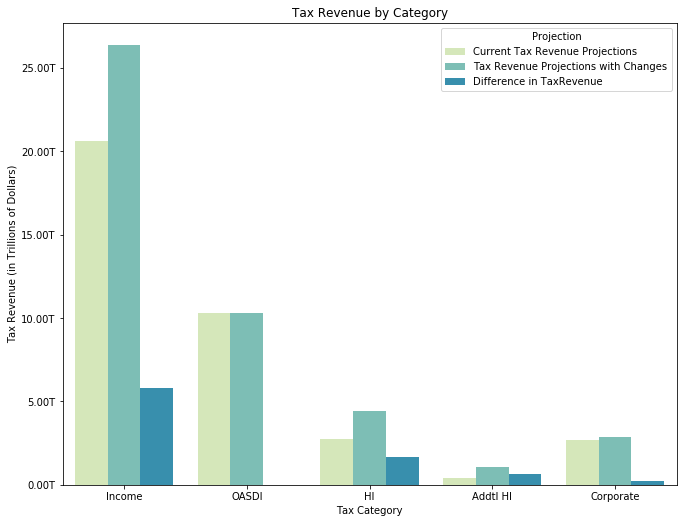

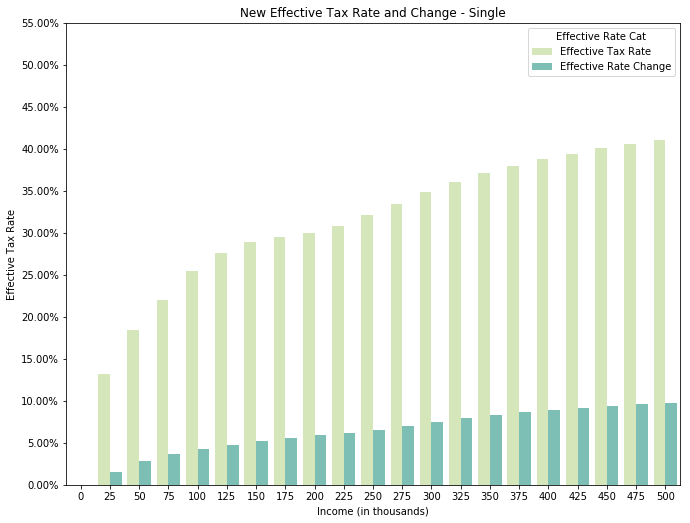

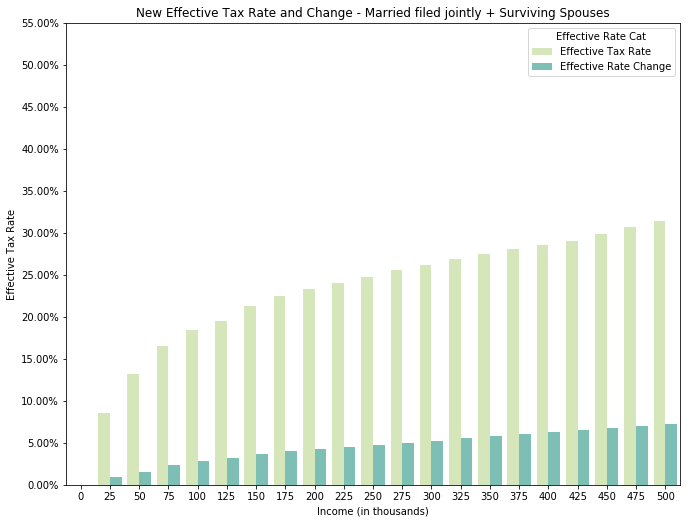

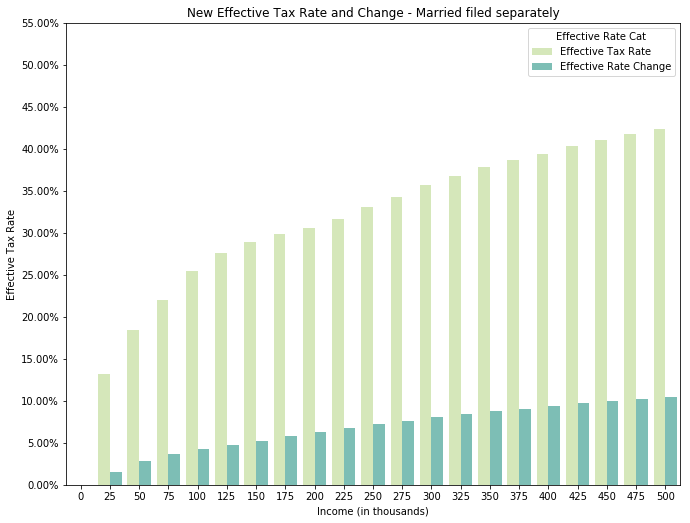

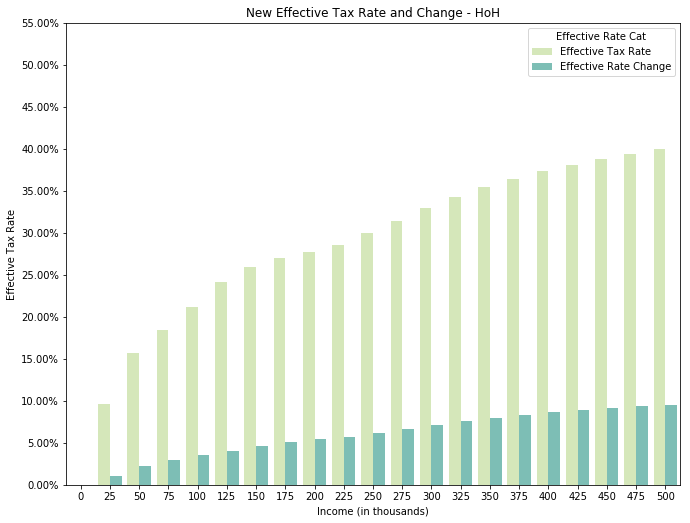

In [37]:
"""
*******************************************************************************
RAISEALLWCONSTRAINT()

Function: project future tax revenue, meeting constraints

Inputs:
    OldBracketDict, a dictionary (current brackets)
    ratio, an int (for progressive income tax brackets)
    OldCorpTaxRate, a float
    OldPayrollTaxList, a list
    StartYear, an int (Year you believe Medicare for All will start)
    Years, an int
    Inflation, a float
    PopulationGrowth, a float
    GDPGrowth, a float
    DesiredCoverage, a float
    TotalCost, an int
    startcovered, an int (0, unless used in final algorithm)
    
    Increments (to raise each tax rate per category; floats):
        incrementI, incrementC, incrementHI, incrementaddtl
    
    Constraints (maximum rates per category; floats):
        maxIncomeTax, maxHItax, maxaddtltax, maxcorptax
    
    Defaults:
        Visualization (True, unless changed)
        
Output:
    [[New Tax Bracket List],[New Payroll Tax Rates],New Corporate Tax Rate,
    Amount Covered by Function, Amount Covered pre Function, Total Amount Covered]
    
    Plots four charts (see above) if Visualization == True
*******************************************************************************
"""
def raiseallwconstraint(OldBracketDict,ratio,OldCorpTaxRate,OldPayrollTaxList,
                        StartYear,Years,Inflation,PopulationGrowth,GDPGrowth,
                        DesiredCoverage,TotalCost,startcovered,
                        incrementI,incrementC,incrementHI,incrementaddtl,
                        maxIncomeTax,maxHItax,maxaddtltax,maxcorptax,
                        Visualization = True):
    
    #initiate variables; amount covered from this function is zero,
    #Raise all rates (income brackets, payroll rates, corp tax rate) by their increments
    amtcovered = 0
    newbracketlist = raiseincometaxbrackets(OldBracketDict,ratio,incrementI)
    NewBracketDict = newbracketdict(OldBracketDict,newbracketlist)
    NewPayrollTaxList = raisepayrolltaxes(OldPayrollTaxList,incrementHI,incrementaddtl)
    NewCorpTaxRate = RaiseCorporateTax(OldCorpTaxRate,incrementC)

    #raise rates by respective increments until amt covered >= desired amt
    while (amtcovered + startcovered) < (DesiredCoverage * TotalCost):
        NoChange = 0
        
        #if current max tax bracket + increment is less than constraint, raise rates
        if round(max(newbracketlist) + (incrementI * ratio),4) > maxIncomeTax or incrementI == 0:
            NoChange += 1
        else:
            newbracketlist = raiseincometaxbrackets(NewBracketDict,ratio,incrementI)
            NewBracketDict = newbracketdict(OldBracketDict,newbracketlist)
        
        #if current payroll tax rates + increment are less than constraints,
        #raise rates
        if NewPayrollTaxList[2] + incrementHI > maxHItax or incrementHI == 0:
            NoChange += 1
        else:
            NewPayrollTaxList = raisepayrolltaxes(NewPayrollTaxList,incrementHI,0)
        if NewPayrollTaxList[3] + incrementaddtl > maxaddtltax or incrementaddtl == 0:
            NoChange += 1
        else:
            NewPayrollTaxList = raisepayrolltaxes(NewPayrollTaxList,0,incrementaddtl)
            
        #if corp tax rate + increment is less than constraint, raise rate
        if NewCorpTaxRate + incrementC > maxcorptax or incrementC == 0:
            NoChange += 1
        else:
            NewCorpTaxRate = RaiseCorporateTax(NewCorpTaxRate,incrementC)
        
        if NoChange == 4:
            break
        
        comparison = compareprojections(OldBracketDict,NewBracketDict,
                                        OldCorpTaxRate,NewCorpTaxRate,
                                        OldPayrollTaxList,NewPayrollTaxList,
                                        StartYear,Years,Inflation,PopulationGrowth,
                                        GDPGrowth,DesiredCoverage,TotalCost)
        amtcovered = comparison[3]
    
    if Visualization == True:
        compareprojections(OldBracketDict,NewBracketDict,OldCorpTaxRate,
                           NewCorpTaxRate,OldPayrollTaxList,NewPayrollTaxList,
                           StartYear,Years,Inflation,PopulationGrowth,GDPGrowth,
                           DesiredCoverage,TotalCost,Visualization = True)

        print('\n' + "Covered $"+ str('{:,}'.format(int(amtcovered + startcovered))) + "; " + \
              str(round((amtcovered + startcovered)/TotalCost * 100,2)) + \
              "% of the total cost ($" + str('{:,}'.format(TotalCost)) + \
              ") vs. goal of " + str(round(DesiredCoverage * 100,2)) + "%")
        print('\n' + 'New Income Brackets: ' + str(newbracketlist) + '\n' + \
              'New HI Payroll Tax Rates: ' + str(NewPayrollTaxList[2:4]) + '\n' + \
              'New Corporate Tax Rate: ' + str(NewCorpTaxRate) + '\n')
    
    return ([newbracketlist,NewPayrollTaxList[2:4],NewCorpTaxRate,
             round(amtcovered,2),startcovered,round(amtcovered+startcovered,2)])
    
raiseallwconstraint(BracketDict2019,7,
                    CurrentCorpTaxRate,
                    PayrollTaxin19,
                    2020,10,Inflation,PopulationGrowth,GDPGrowth,
                    0.25,30000000000000,0,
                    0.0025,0.0025,0.0025,0.0025,0.55,0.05,0.05,0.35)


### Algo: Raise all rates, with constraints, and with the lowest impact for specified filing status & income


Covered $15,070,954,784,402; 50.24% of the total cost ($30,000,000,000,000) vs. goal of 50.0%

New Income Brackets: [0.181, 0.2172, 0.3253, 0.3615, 0.4577, 0.4958, 0.532]
New HI Payroll Tax Rates: [0.029, 0.05]
New Corporate Tax Rate: 0.3



[[0.181, 0.2172, 0.3253, 0.3615, 0.4577, 0.4958, 0.532],
 0.029,
 0.05,
 0.3,
 15070954784402.71]

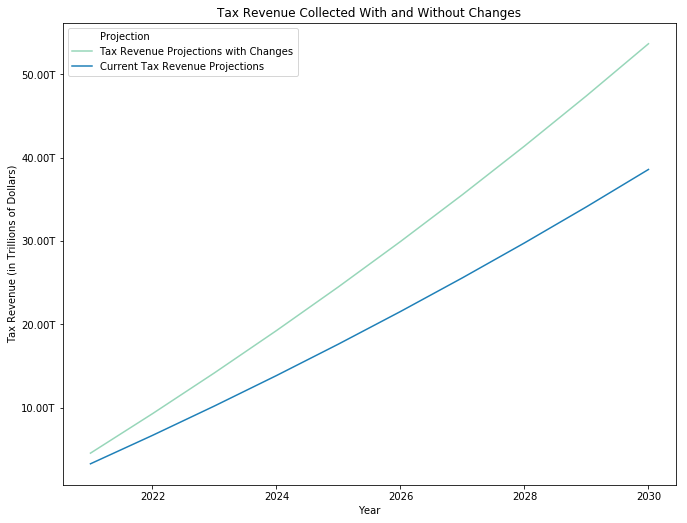

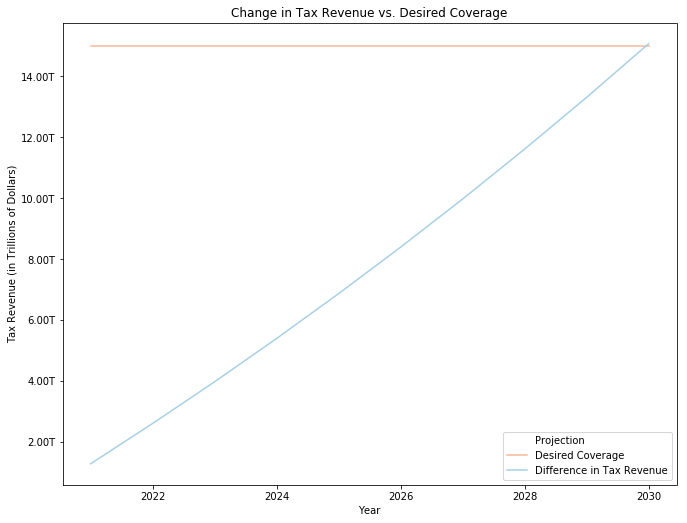

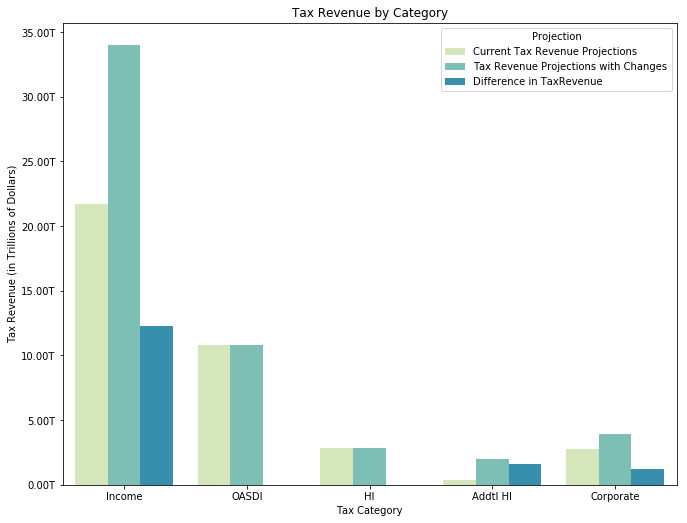

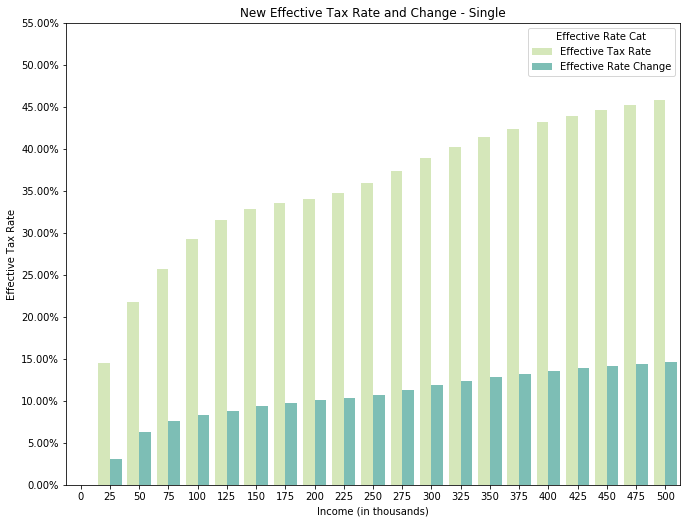

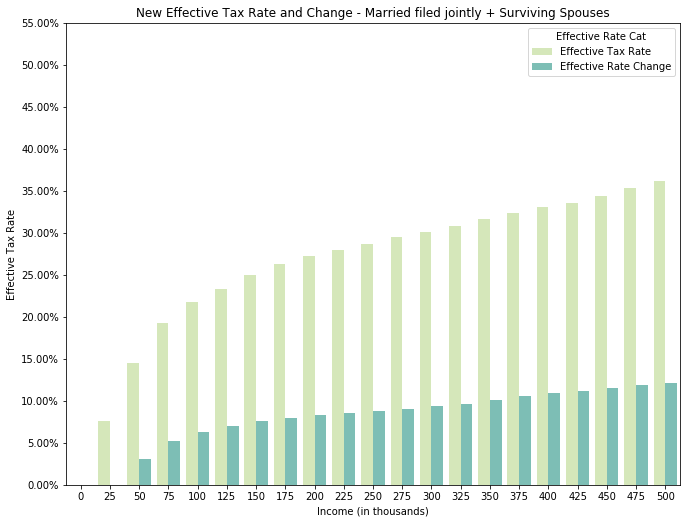

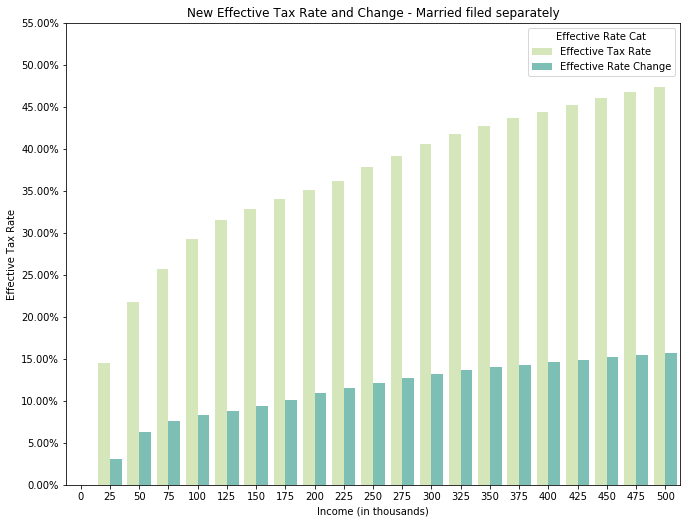

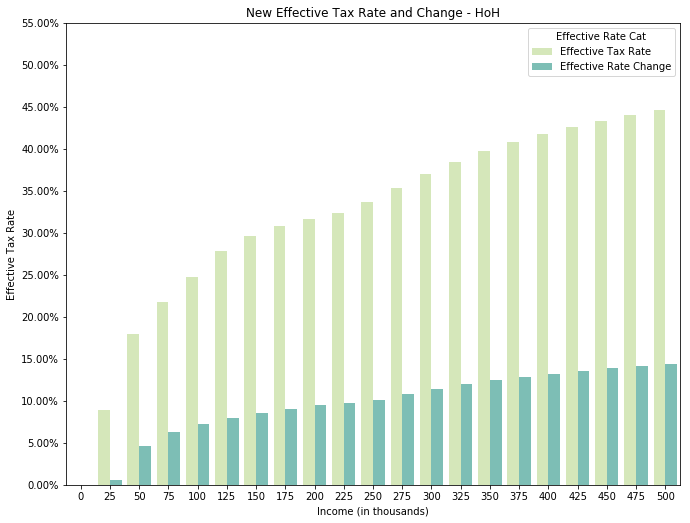

In [38]:
"""
*******************************************************************************
RAISEALLFORAGIVENINCOME()

Function: Raise tax rates, meeting constraints, and choosing the option with 
the lowest impact for a person with a specified filing status and income

(i.e. determine marginal effective tax rate increase from raising each rate
by a certain increment)

Inputs:

    OldBracketDict, a dictionary
    OldCorpTaxRate, a float
    OldPayrollTaxList, a list
    StartYear, an int
    Years, an int
    Inflation, a float
    PopulationGrowth, a float
    GDPGrowth, a float
    ratio, an int
    increment, a float
    
    Constraints:
        Desired Coverage, a float
        Total Cost, an int
        startcovered, a float
        maxIncomeTax, a float
        maxHItax, a float
        maxaddtltax, a float
        maxcorptax, a float
        Income, an int
        Status, a string
    
Output: list
    [[Income Tax Brackets],HI Payroll Tax, HI addt'l Payroll Tax, Corporate Tax,
    amount covered by rate changes]
*******************************************************************************
"""
def raiseallforagivenincome(OldBracketDict,OldCorpTaxRate,OldPayrollTaxList,
                            StartYear,Years,Inflation,PopulationGrowth,GDPGrowth,
                            ratio,increment,DesiredCoverage,TotalCost,startcovered,
                            maxIncomeTax,maxHItax,maxaddtltax,maxcorptax,
                            Income,Status,Visualization = True):
    
    margrate = marginaltaxincrease(OldBracketDict,OldPayrollTaxList,ratio,
                                   increment,StartYear + Years,Income,Status,Inflation)
        
    covered = 0
    margrate.sort(key = lambda x: x[1])
    for t in margrate:
        if t[0] == 'IncomeTax':
            if covered >= DesiredCoverage * TotalCost:
                increment = 0
            incometaxchange = raiseallwconstraint(OldBracketDict,ratio,OldCorpTaxRate,
                                                  OldPayrollTaxList,StartYear,Years,Inflation,
                                                  PopulationGrowth,GDPGrowth,
                                                  DesiredCoverage,TotalCost,covered,
                                                  increment,0,0,0,
                                                  maxIncomeTax,maxHItax,maxaddtltax,maxcorptax,
                                                  Visualization = False)
            covered += incometaxchange[3]
            
        elif t[0] == 'CorpTax':
            if covered >= DesiredCoverage * TotalCost:
                increment = 0
            corptaxchange = raiseallwconstraint(OldBracketDict,ratio,OldCorpTaxRate,
                                                OldPayrollTaxList,StartYear,Years,Inflation,
                                                PopulationGrowth,GDPGrowth,
                                                DesiredCoverage,TotalCost,covered,
                                                0,increment,0,0,
                                                maxIncomeTax,maxHItax,maxaddtltax,maxcorptax,
                                                Visualization = False)
            covered += corptaxchange[3]
            
        elif t[0] == 'HITax':
            if covered >= DesiredCoverage * TotalCost:
                increment = 0
            HItaxchange = raiseallwconstraint(OldBracketDict,ratio,OldCorpTaxRate,
                                              OldPayrollTaxList,StartYear,Years,Inflation,
                                              PopulationGrowth,GDPGrowth,
                                              DesiredCoverage,TotalCost,covered,
                                              0,0,increment,0,
                                              maxIncomeTax,maxHItax,maxaddtltax,maxcorptax,
                                              Visualization = False)
            covered += HItaxchange[3]
            
        elif t[0] == 'AddtlHITax':
            if covered >= DesiredCoverage * TotalCost:
                increment = 0
            addtlHItaxchange = raiseallwconstraint(OldBracketDict,ratio,OldCorpTaxRate,
                                                   OldPayrollTaxList,StartYear,Years,Inflation,
                                                   PopulationGrowth,GDPGrowth,
                                                   DesiredCoverage,TotalCost,covered,
                                                   0,0,0,increment,
                                                   maxIncomeTax,maxHItax,maxaddtltax,maxcorptax,
                                                   Visualization = False)
            covered += addtlHItaxchange[3]

    if Visualization == True:
        NewBracketDict = newbracketdict(OldBracketDict,incometaxchange[0])
        NewPayrollTaxList = newpayrolllist(OldPayrollTaxList,[HItaxchange[1][0],addtlHItaxchange[1][1]])
        compareprojections(OldBracketDict,NewBracketDict,
                           OldCorpTaxRate,corptaxchange[2],
                           OldPayrollTaxList,NewPayrollTaxList,
                           StartYear,Years,Inflation,PopulationGrowth,
                           GDPGrowth,DesiredCoverage,TotalCost,Visualization = True)    
        
        print('\n' + "Covered $"+ str('{:,}'.format(int(covered + startcovered))) + "; " + \
              str(round((covered + startcovered)/TotalCost * 100,2)) + \
              "% of the total cost ($" + str('{:,}'.format(TotalCost)) + \
              ") vs. goal of " + str(round(DesiredCoverage * 100,2)) + "%")
        
        print('\n' + 'New Income Brackets: ' + str(incometaxchange[0]) + '\n' + \
              'New HI Payroll Tax Rates: ' + str(NewPayrollTaxList[2:4]) + '\n' + \
              'New Corporate Tax Rate: ' + str(corptaxchange[2]) + '\n')
        
    return [incometaxchange[0],HItaxchange[1][0],addtlHItaxchange[1][1],corptaxchange[2],covered]

raiseallforagivenincome(BracketDict2019,CurrentCorpTaxRate,PayrollTaxin19,
                        2021,10,0.02,0.01,0.02,2,0.001,0.50,30000000000000,
                        0,0.55,0.05,0.05,0.30,100000,"Married filed jointly + Surviving Spouses")

### Algo: "Plug and Play" -- user inputs desired rates/assumptions

In [ ]:
"""
*******************************************************************************
PLUGANDPLAY()

Function: DIY plug and play new tax rates and assumptions

Inputs:
    Defaults:
        OldBracketDict, a dictionary
        OldCorpTaxRate, a float
        OldPayrollTaxList, a list

Output: total covered, a float
*******************************************************************************
"""
def plugandplay(OldBracketDict = BracketDict2019,OldCorpTaxRate = CurrentCorpTaxRate,
                OldPayrollTaxList = PayrollTaxin19):
    
    CurrBrackets = []
    for key in OldBracketDict.keys():
        for br in OldBracketDict[key].keys():
            if float(br) * 100 not in CurrBrackets:
                CurrBrackets.append(round(float(br) * 100,2))
    
    print("\n" + "***************************" + "\n" + "Current Income Tax Brackets are " + str(CurrBrackets))
    while True:
        NewBracketList = input("Please list 7 new income tax rates, in format: 10.00,20.00 etc: ")
        temp = []
        currentnum = ""        
        for n in NewBracketList:
            if n == "." or n in string.digits:
                currentnum = currentnum + n
            elif n == ',':
                temp.append(round(float(currentnum)/100,4))
                currentnum = ""
        temp.append(round(float(currentnum)/100,4))
        if len(temp) == 7:
            break    
    NewBracketDict = newbracketdict(OldBracketDict,temp)
    
    print("\n" + "***************************" + "\n" + 
          "Current HI Payroll Tax Rates are: Base Rate: " + str(round(OldPayrollTaxList[2] * 100/2,2)) + \
          "; Addt'l Rate (Income > $200,000): " + str(round(OldPayrollTaxList[3] * 100,2)))
    while True:
        NewPayrollTaxes = input("Please list your base and additional HI (Medicare) tax rates, in format: 1.00,2.00: ")
        temp = []
        currentnum = ""        
        for n in NewPayrollTaxes:
            if n == "." or n in string.digits:
                currentnum = currentnum + n
            elif n == ',':
                temp.append(round(float(currentnum)/100,4))
                currentnum = ""
        temp.append(round(float(currentnum)/100,4))
        if len(temp) == 2:
            break
    temp[0] = temp[0] * 2
    NewPayrollTaxList = newpayrolllist(OldPayrollTaxList,temp)
    
    print("\n" + "***************************" + "\n" + "CurrentCorporate Tax Rate is " + str(OldCorpTaxRate * 100))
    NewCorpTaxRate = input("Please list your new Corporate Tax Rate, in format: 1.00: ")
    currentnum = ""        
    for n in NewCorpTaxRate:
        if n == "." or n in string.digits:
            currentnum = currentnum + n
    NewCorpTaxRate = round(float(currentnum)/100,4)
            
    StartYear = int(input("Please choose a starting year (beyond 2019), in format 2020: "))
    
    Years = int(input("Please choose number of years to project revenue, in format 10: "))
    
    TotalCost = input("Please choose a total cost over years specified, in format 10000000: ")
    TotalCost = int(TotalCost.replace(',',''))
    
    InflationEst = input("Please choose an estimated Inflation Rate, in format: 1.00: ")
    currentnum = ""        
    for n in InflationEst:
        if n == "." or n in string.digits:
            currentnum = currentnum + n
    InflationEst = round(float(currentnum)/100,4)
    
    PopulationGrowthEst = input("Please choose an estimated Population Growth Rate, in format: 1.00: ")
    currentnum = ""        
    for n in PopulationGrowthEst:
        if n == "." or n in string.digits:
            currentnum = currentnum + n
    PopulationGrowthEst = round(float(currentnum)/100,4)
    
    GDPGrowthEst = input("Please choose an estimated GDP Growth Rate, in format: 1.00: ")
    currentnum = ""        
    for n in GDPGrowthEst:
        if n == "." or n in string.digits:
            currentnum = currentnum + n
    GDPGrowthEst = round(float(currentnum)/100,4)
    
    DesiredCoverage = input("Please choose a Desired Coverage Rate, in format: 1.00: ")
    currentnum = ""        
    for n in DesiredCoverage:
        if n == "." or n in string.digits:
            currentnum = currentnum + n
    DesiredCoverage = round(float(currentnum)/100,4)
    
    covered = compareprojections(OldBracketDict,NewBracketDict,
                                 OldCorpTaxRate,NewCorpTaxRate,
                                 OldPayrollTaxList,NewPayrollTaxList,
                                 StartYear,Years,InflationEst,PopulationGrowthEst,
                                 GDPGrowthEst,DesiredCoverage,TotalCost,
                                 Visualization = True)
    
    print("\n" + \
          "You were able to cover $"+str('{:,}'.format(covered[3]))+";" + "\n" + \
          "this is " + str(round(covered[3]/TotalCost*100,4)) + "%, vs. your goal of " + str(DesiredCoverage*100) + "%" \
          + "\n")
    
    return covered[3]
    
print(plugandplay())